# ARC - Abstraction and Reasoning Corpus - Geometry Simple Solvers

The Abstraction and Reasoning Corpus (ARC) contains 400+400=800 training + evaluation tasks, with Kaggle testing on 100+100=200 tasks.

# Links and Resources

Competition Data
- https://github.com/fchollet/ARC - Original Dataset Source

Papers
- https://arxiv.org/pdf/1911.01547.pdf - On the Measure of Intelligence - Francois Chollet's writeup of the problem space

Visualization of Tasks
- https://www.kaggle.com/zaharch/visualizing-all-tasks-updated
- https://www.kaggle.com/boliu0/visualizing-all-task-pairs-with-gridlines
- https://www.kaggle.com/maxjeblick/play-arc-interactively - Interactive Manual Solver

Code Snippits
- https://www.kaggle.com/inversion/abstraction-and-reasoning-starter-notebook - Basic Input / Output Code
- https://www.kaggle.com/nagiss/manual-coding-for-the-first-10-tasks - Manual Coding
- https://www.kaggle.com/paulorzp/15-tasks-crop-resize-repeat - +15 tasks (Crop, Resize, Repeat)

Suggested Methodologies
- https://www.kaggle.com/tarunpaparaju/arc-competition-eda-pytorch-cnn - PyTorch Machine Learning CNNs
- https://www.kaggle.com/arsenynerinovsky/cellular-automata-as-a-language-for-reasoning - Cellular Automata
- https://www.kaggle.com/zenol42/dsl-and-genetic-algorithm-applied-to-arc - DSL + Genetic Algorithms 
- https://www.kaggle.com/meaninglesslives/using-decision-trees-for-arc - Decision Trees

Other Approaches
- http://www.cs.toronto.edu/~sheila/2542/w09/A1/introtopddl2.pdf - PDDL (Planning Domain Definition Language) + Astar Search
- https://stackoverflow.com/questions/613146/computing-the-difference-between-images - Image Differencing

# Multi-Model Approach

Some of the above resources suggest a single general-purpose solver algorithm for the entire corpus. However it may be possible to divide the corpus into several different classes of problem, some of which may have simple solutions. 

The first challenge is to identifiy common classes of problems and subproblems, some of which are mentioned in Francois Chollet's paper [On the Measure of Intelligence](https://arxiv.org/pdf/1911.01547.pdf)

Problems

- Geometry
    - do nothing
    - rotate / mirror / shift image
    - crop image background
    - draw border


- Objects
    - rotate / mirror / shirt objects
    - move two objects together
    - move objects to edge
    - extend / repeat an object
    - delete an object
    - count unique objects and select the object that appears the most times
    - create pattern based on image colors
    - overlay object
    - replace objects


- Coloring
    - select colors for objects
    - select dominant/smallest color in image
    - denoise
    - fill in empty spaces


- Lines
    - color edges
    - extrapolate a straight/diagonal line
    - draw a line between two dots / or inersections between such lines
    - draw a spiral


- Grids
    - select grid squares with most pixels


- Patterns
    - complete a symmetrical/repeating pattern 


- Subtasks
    - object detection / cohesion / seperation
    - object persistance
    - counting or sorting objects


If such problem classes can be correctly detected, it may be possible to get some quick wins by writing a libary of simple solvers for known problems. These could be tried in sequence before resorting to more advanced general purpose algorithms.

# Loading the Data

In [1]:
import numpy as np
import pandas as pd

import sys
import os
import re
import json
import cv2
import itertools
import traceback
from itertools import chain, product, combinations
from glob import glob
from pathlib import Path
from copy import copy, deepcopy

import matplotlib.pyplot as plt
from matplotlib import colors


import toolz
import pydash as py
from pydash import py_ as _

In [2]:
task_files = glob('../input/abstraction-and-reasoning-challenge/**/*.json')

def load_tasks(task_files):
    if isinstance(task_files, str): task_files = glob(task_files)
        
    tasks = { re.sub(r'^.*/(.*?/.*$)','\\1',file): json.load(open(file, 'r')) for file in task_files }

    for file, task in tasks.items():
        for test_train, specs in task.items():
            for index, spec in enumerate(specs):
                for input_output, grid in spec.items():
                    tasks[file][test_train][index][input_output] = np.array(grid).astype('uint8')  # uint8 required for cv2 

    for file, task in tasks.items():
        tasks[file]['file'] = file
    return tasks

tasks = load_tasks(task_files)
task = list(tasks.values())[6]; task

{'train': [{'input': array([[9, 9, 6],
          [3, 8, 8],
          [8, 3, 3]], dtype=uint8),
   'output': array([[0, 0, 0, 0, 0, 0, 9, 9, 6],
          [0, 0, 0, 0, 0, 0, 3, 8, 8],
          [0, 0, 0, 0, 0, 0, 8, 3, 3],
          [0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)},
  {'input': array([[8, 5, 5],
          [8, 8, 8],
          [5, 9, 9]], dtype=uint8),
   'output': array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 8, 5, 5, 8, 5, 5],
          [0, 0, 0, 8, 8, 8, 8, 8, 8],
          [0, 0, 0, 5, 9, 9, 5, 9, 9]], dtype=uint8)},
  {'input': array([[7, 1, 7],
          [1, 7, 7],
          [7

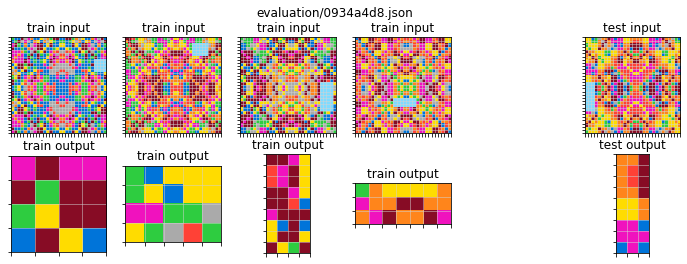

In [3]:
# Modified from Source: https://www.kaggle.com/zaharch/visualizing-all-tasks-updated
def plot_one(task, ax, i,train_or_test,input_or_output):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    
    try:
        input_matrix = task[train_or_test][i][input_or_output]
        ax.imshow(input_matrix, cmap=cmap, norm=norm)
        ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
        ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
        ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title(train_or_test + ' '+input_or_output)
    except: pass  # mat throw on tests, as they have not "output"
    
def plot_task(task, scale=2):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """   
    filename = None
    if isinstance(task, str):   (filename, task) = task, tasks[task]
    if isinstance(task, tuple): (filename, task) = task
    if 'file' in task: filename = task['file']
    
    num_train = len(task['train']) + len(task['test']) + 1
    if 'solution' in task: num_train += len(task['solution']) + 1
    
    fig, axs = plt.subplots(2, num_train, figsize=(scale*num_train,scale*2))
    if filename: fig.suptitle(filename)
        
    for i in range(len(task['train'])):     
        plot_one(task, axs[0,i],i,'train','input')
        plot_one(task, axs[1,i],i,'train','output')            

    axs[0,i+1].axis('off'); axs[1,i+1].axis('off')
    for j in range(len(task['test'])):      
        plot_one(task, axs[0,i+2+j],j,'test','input')
        plot_one(task, axs[1,i+2+j],j,'test','output')  
    
    if 'solution' in task:    
        axs[0,i+j+3].axis('off'); axs[1,i+j+3].axis('off')        
        for k in range(len(task['solution'])):      
            plot_one(task, axs[0,i+j+4+k],k,'solution','input')
            plot_one(task, axs[1,i+j+4+k],k,'solution','output')  

    plt.show()     
    
plot_task(list(tasks.items())[0])

# Do Nothing

The simplest problem is the Do Nothing problem. The input and the output are exactly the same.
- This didn't find anything

In [4]:
solvers = {}

In [5]:
class Solver():
    verbose = False
    debug   = False
    def __init__(self):
        self.cache = {}
    
    @staticmethod
    def loop_specs(task, test_train='train'):
        specs = task[test_train]
        for index, spec in enumerate(specs):
            yield { 'input': spec['input'], 'output': spec['output'] }

    @staticmethod
    def is_lambda_valid(_task_, _function_, *args, **kwargs):  # _task_ = avoid namespace conflicts with kwargs=task 
        for spec in Solver.loop_specs(_task_, 'train'):
            output = _function_(spec['input'], *args, **kwargs)
            if not np.array_equal( spec['output'], output):
                return False
        return True

    @staticmethod
    def solve_lambda(_task_, _function_, *args, **kwargs):
        solution = []
        for index, spec in enumerate(_task_['test']):
            output = _function_(spec['input'], *args, **kwargs)
            solution.append({ 
                "input":  spec['input'],
                "output": output
            })
        return solution

    def action(self, grid, *args):
        """This is the primary method this needs to be defined"""
        return grid
        raise NotImplementedError()

    def detect(self, task):
        """default heuristic is simply to run the solver""" 
        return self.test(task)

    def test(self, task):
        """test if the given action correctly solves the task"""
        args = self.cache.get(task['file'], ())
        return self.is_lambda_valid(task, self.action, *args, task=task)    

    def solve(self, task, force=False):
        """solve test case and persist"""
        try:
            if self.detect(task) or force:    # may generate cache
                if self.test(task) or force:  # may generate cache
                    args     = self.cache.get(task['file'], ())
                    if self.verbose and args:
                        print('solved: ', self.__class__.__name__, args)
                    if isinstance(args, dict):
                        solution = self.solve_lambda(task, self.action, **args, task=task)                    
                    else:
                        solution = self.solve_lambda(task, self.action, *args, task=task)
                    task['solution'] = solution  # TODO: fix for multiple test outputs
                    return solution
        except Exception as exception:
            if self.debug: raise exception
        return None
            
    def solve_all(self, tasks, plot=False, solve_detects=False):
        count = 0
        for filename, task in tasks.items():    
            if self.detect(task):
                solution = self.solve(task, force=solve_detects)
                if solution or (solve_detects and self.test(task)):
                    count += 1
                    if plot == True:
                        plot_task((filename, task))        
        return count

    def plot(self, tasks):
        return self.solve_all(tasks, plot=True, solve_detects=False)

    def plot_detects(self, tasks, unsolved=True):
        if unsolved:
            tasks = { file: task for (file,task) in deepcopy(tasks).items() if not 'solution' in task }
        return self.solve_all(tasks, plot=True, solve_detects=True)

        
    ### Helper Methods ###
    
    @staticmethod
    def grid_shape_ratio(grid1, grid2):
        try:
            return ( grid2.shape[0] / grid1.shape[0], grid2.shape[1] / grid1.shape[1] )
        except:
            return (0, 0)  # For tests
    
    @staticmethod
    def task_grids(task):
        grids = []
        for test_train in ['test','train']:
            for spec in task[test_train]:
                grids += [ spec.get('input',[]), spec.get('output',[]) ]  # tests not gaurenteed to have outputs
        return grids

    @staticmethod
    def task_grid_shapes(task):
        return [ np.array(grid).shape for grid in Solver.task_grids(task) ]
    
    @staticmethod
    def task_grid_max_dim(task):
        return max(chain(*Solver.task_grid_shapes(task)))
    
    @staticmethod
    def task_shape_ratios(task):
        ratios = set([
            Solver.grid_shape_ratio(spec.get('input',[]), spec.get('output',[]))
            for spec in Solver.loop_specs(task, 'train')
        ])
        # ratios = set([ int(ratio) if ratio.is_integer() else ratio for ratio in chain(*ratios) ])
        return ratios

    @staticmethod
    def is_task_shape_ratio_unchanged(task):
        return Solver.task_shape_ratios(task) == { (1,1) }

    @staticmethod
    def is_task_shape_ratio_consistant(task):
        return len(Solver.task_shape_ratios(task)) == 1
    
    @staticmethod
    def is_task_shape_ratio_integer_multiple(task):
        ratios = Solver.task_shape_ratios(task)
        return all([ isinstance(d, int) or d.is_integer() for d in chain(*ratios) ])
        
    
print( 'Solver().task_grid_shapes(task)',                     Solver().task_grid_shapes(task)  )
print( 'Solver().task_grid_max_dim(task)',                    Solver().task_grid_max_dim(task) )
print( 'Solver().task_shape_ratios(task)',                    Solver().task_shape_ratios(task) )
print( 'Solver().is_task_shape_ratio_consistant(task)',       Solver().is_task_shape_ratio_consistant(task) )
print( 'Solver().is_task_shape_ratio_unchanged(task)',        Solver().is_task_shape_ratio_unchanged(task)  )
print( 'Solver().is_task_shape_ratio_integer_multiple(task)', Solver().is_task_shape_ratio_integer_multiple(task) )

Solver().task_grid_shapes(task) [(3, 3), (9, 9), (3, 3), (9, 9), (3, 3), (9, 9), (3, 3), (9, 9), (3, 3), (9, 9), (3, 3), (9, 9), (3, 3), (9, 9)]
Solver().task_grid_max_dim(task) 9
Solver().task_shape_ratios(task) {(3.0, 3.0)}
Solver().is_task_shape_ratio_consistant(task) True
Solver().is_task_shape_ratio_unchanged(task) False
Solver().is_task_shape_ratio_integer_multiple(task) True


In [6]:
class DoNothingSolver(Solver):
    def action(self, grid, task):
        return grid

solvers['DoNothingSolver'] = DoNothingSolver()
solvers['DoNothingSolver'].plot(tasks)

0

DoNothingSolver found nothing

# Rescale Image

Zooming in and out can be performed using `cv2.resize()` and `skimage.measure.block_reduce()`. We get 4 matches.

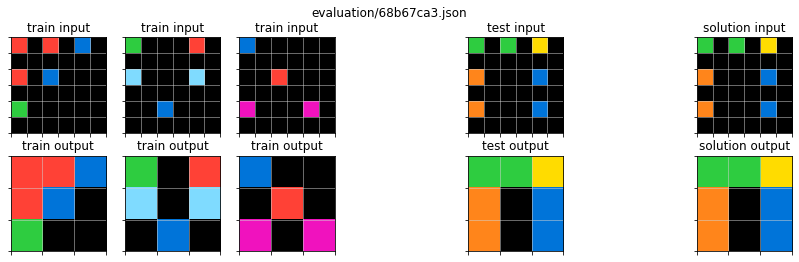

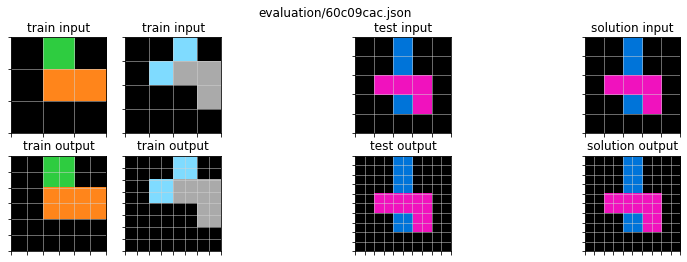

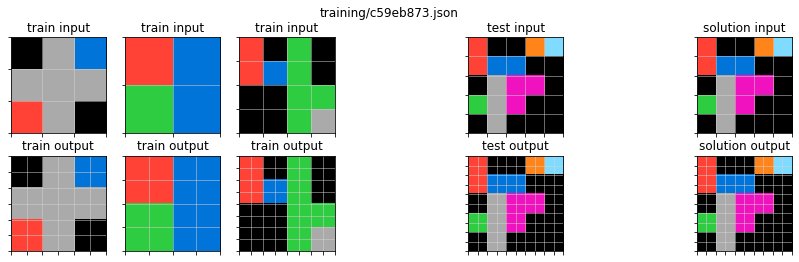

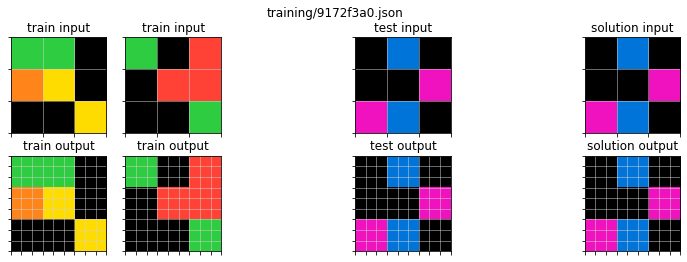

4

In [7]:
import skimage.measure

class ZoomSolver(Solver):
    verbose = False
    
    def detect(self, task):
        ratios = self.task_shape_ratios(task)
        ratio  = list(ratios)[0] 
        detect = (
                ratios != { (1,1) }   # not no scaling
            and len(ratios) == 1      # not multiple scalings
            and ratio[0] == ratio[1]  # single consistant scaling
        )
        return detect

    def get_scale(self, task):
        return list(self.task_shape_ratios(task))[0][0]
            
    def action(self, grid, task):
        scale = self.get_scale(task)
        if scale > 1:
            resize = tuple( int(d*scale) for d in grid.shape )            
            output = cv2.resize(grid, resize, interpolation=cv2.INTER_NEAREST)
        else:
            resize = tuple( int(1/scale) for d in grid.shape )                        
            output = skimage.measure.block_reduce(grid, resize)
        if self.verbose:
            print('scale', scale, 'grid.shape', grid.shape, 'output.shape', output.shape)
            print('grid', grid)
            print('output', output)            
        return output

solvers['ZoomSolver'] = ZoomSolver()
ZoomSolver().plot(tasks)

# Geometry Problems

Here we just apply a set of prebuilt numpy geometry functions, and get 8 matches

<function rot90 at 0x7fcd00a58680> (1,)
solved:  GeometrySolver (<function rot90 at 0x7fcd00a58680>, (1,))


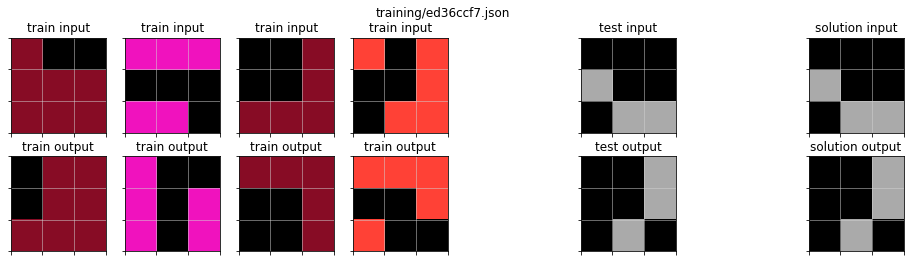

<function swapaxes at 0x7fcd08039710> (0, 1)
solved:  GeometrySolver (<function swapaxes at 0x7fcd08039710>, (0, 1))


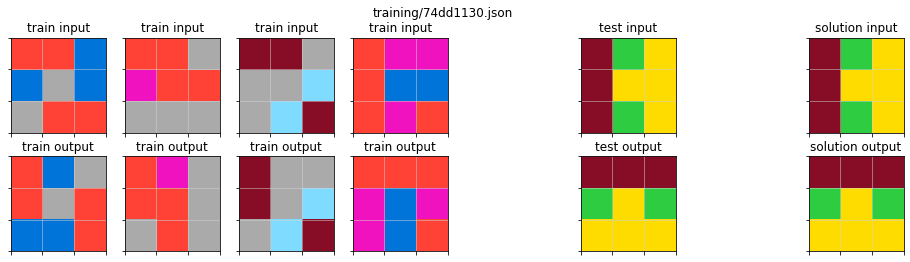

<function roll at 0x7fcd08057680> (-2, 0)
solved:  GeometrySolver (<function roll at 0x7fcd08057680>, (-2, 0))


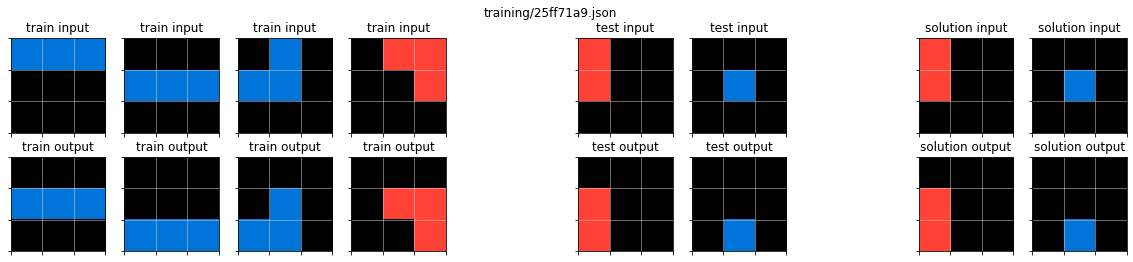

<function swapaxes at 0x7fcd08039710> (0, 1)
solved:  GeometrySolver (<function swapaxes at 0x7fcd08039710>, (0, 1))


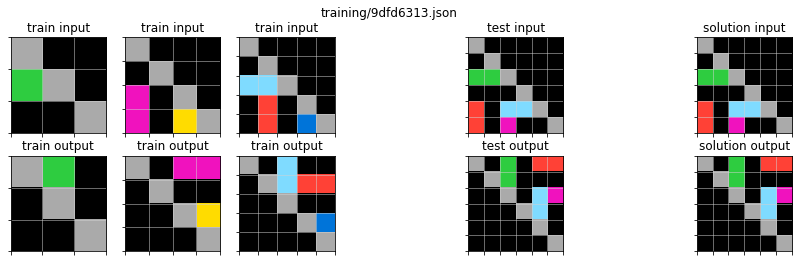

<function flip at 0x7fcd00a588c0> (0,)
solved:  GeometrySolver (<function flip at 0x7fcd00a588c0>, (0,))


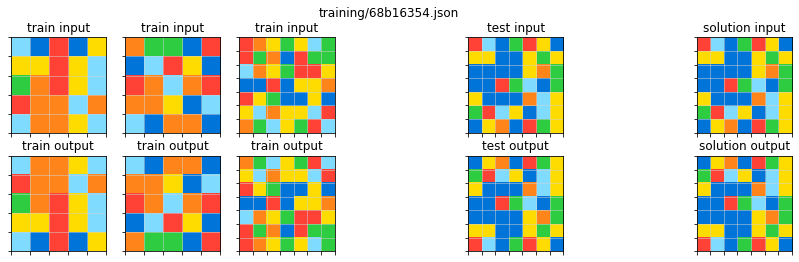

<function rot90 at 0x7fcd00a58680> (2,)
solved:  GeometrySolver (<function rot90 at 0x7fcd00a58680>, (2,))


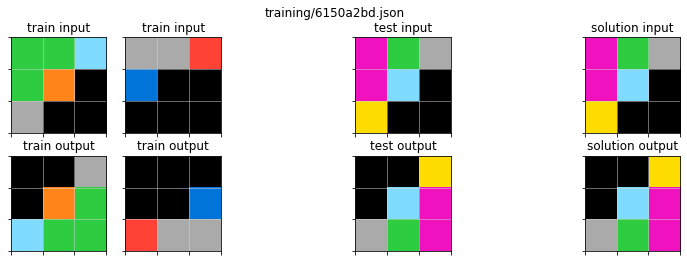

<function flip at 0x7fcd00a588c0> (1,)
solved:  GeometrySolver (<function flip at 0x7fcd00a588c0>, (1,))


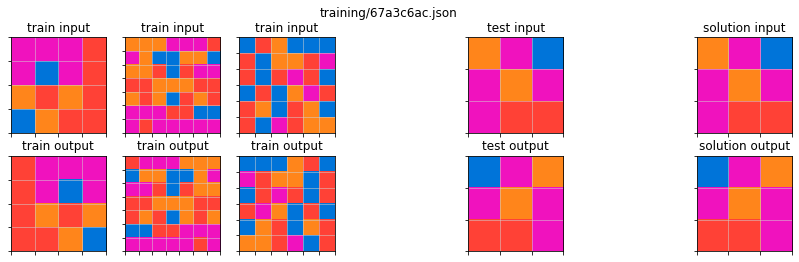

<function rot90 at 0x7fcd00a58680> (2,)
solved:  GeometrySolver (<function rot90 at 0x7fcd00a58680>, (2,))


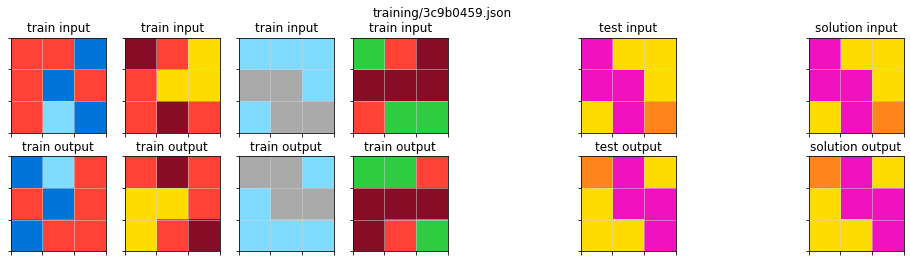

8

In [8]:
class GeometrySolver(Solver):
    optimise = True
    verbose  = True
    actions = {
        "flip":      ( np.flip,      [0,1]    ),
        "rot90":     ( np.rot90,     [1,2,3]  ),
        "roll":      ( np.roll,      product(range(-5,5),[0,1]) ),  
        "swapaxes":  ( np.swapaxes,  [(0, 1),(1, 0)] ),             
        "transpose": ( np.transpose, []       ),                      # this doesn't find anything                
    }
    
    def __init__(self):
        super().__init__()
        for key, (function, arglist) in self.actions.items():
            self.actions[key] = (function, [ (args,) if not isinstance(args, tuple) else args for args in arglist ])            
    
    def detect(self, task):
        return self.is_task_shape_ratio_unchanged(task)  # grids must remain the exact same size
        
    def test(self, task):
        if task['file'] in self.cache: return True
        
        max_roll = (self.task_grid_max_dim(task) + 1) // 2 
        for key, (function, arglist) in self.actions.items():
            if function == np.roll: arglist = product(range(-max_roll,max_roll),[0,1]) 
            for args in arglist:
                if self.is_lambda_valid(task, function, *args):
                    self.cache[task['file']] = (function, args)
                    if self.verbose: print(function, args)
                    return True
                
        # this doesn't find anything
        if self.optimise: return False        
        for ((function1, arglist1),(function2, arglist2)) in combinations( self.actions.values(), 2 ):
            if function1 == np.roll: arglist1 = product(range(-max_roll,max_roll),[0,1]) 
            if function2 == np.roll: arglist2 = product(range(-max_roll,max_roll),[0,1]) 
            for args1, args2 in product(arglist1, arglist2):
                function = lambda grid, args1, args2: function1(function2(grid, *args2), *args1)                
                if self.is_lambda_valid(task, function, *(args1,args2)):
                    self.cache[task['file']] = (function, (args1,args2))
                    if self.verbose: print(function, (args1,args2))
                    return True
        return False
    
    def action(self, grid, function=None, args=None, task=None):
        try:
            return function(grid, *args)
        except Exception as exception:
            if self.verbose: print(function, args, exception)
            return grid

solvers['GeometrySolver'] = GeometrySolver()
GeometrySolver().plot(tasks)    

# Tessellation Problems

<bound method TessellationSolver.action of <__main__.TessellationSolver object at 0x7fcce6c52d10>> {'preprocess': <function copy at 0x7fcd00a5b320>, 'p_arg': (), 'transform': <function copy at 0x7fcd00a5b320>, 't_arg': (), 'query': <function query_max_color at 0x7fccdaa53200>, 'q_arg': ()}
solved:  TessellationSolver {'preprocess': <function copy at 0x7fcd00a5b320>, 'p_arg': (), 'transform': <function copy at 0x7fcd00a5b320>, 't_arg': (), 'query': <function query_max_color at 0x7fccdaa53200>, 'q_arg': ()}


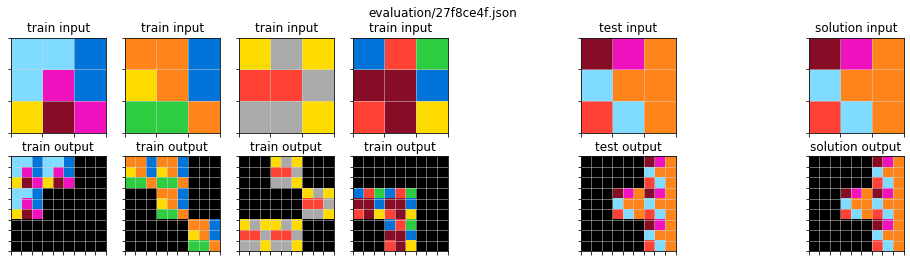

<bound method TessellationSolver.action of <__main__.TessellationSolver object at 0x7fcce6c52d10>> {'preprocess': <function copy at 0x7fcd00a5b320>, 'p_arg': (), 'transform': <function copy at 0x7fcd00a5b320>, 't_arg': (), 'query': <function query_not_zero at 0x7fccdaa53b00>, 'q_arg': ()}
solved:  TessellationSolver {'preprocess': <function copy at 0x7fcd00a5b320>, 'p_arg': (), 'transform': <function copy at 0x7fcd00a5b320>, 't_arg': (), 'query': <function query_not_zero at 0x7fccdaa53b00>, 'q_arg': ()}


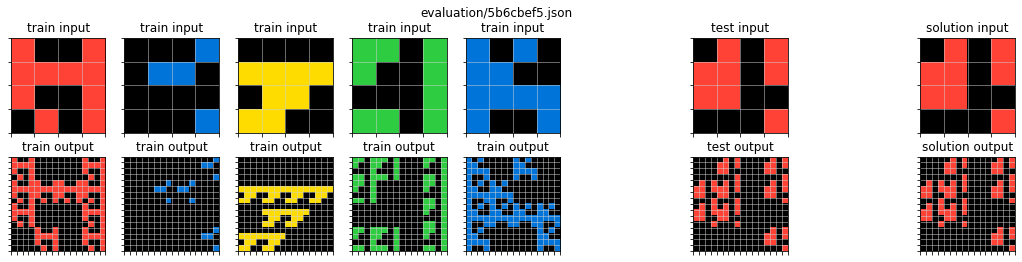

<bound method TessellationSolver.action of <__main__.TessellationSolver object at 0x7fcce6c52d10>> {'preprocess': <function copy at 0x7fcd00a5b320>, 'p_arg': (), 'transform': <function copy at 0x7fcd00a5b320>, 't_arg': (), 'query': <function query_max_color at 0x7fccdaa53200>, 'q_arg': ()}
solved:  TessellationSolver {'preprocess': <function copy at 0x7fcd00a5b320>, 'p_arg': (), 'transform': <function copy at 0x7fcd00a5b320>, 't_arg': (), 'query': <function query_max_color at 0x7fccdaa53200>, 'q_arg': ()}


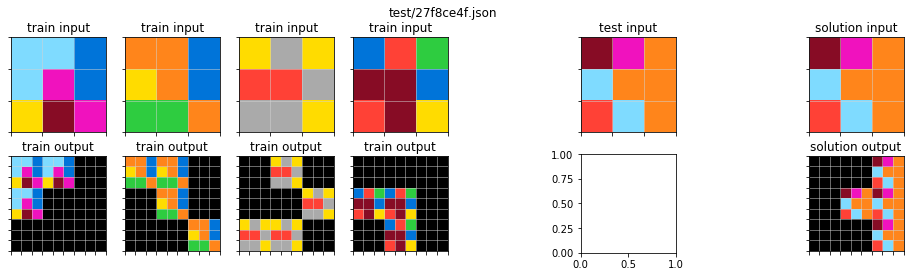

<bound method TessellationSolver.action of <__main__.TessellationSolver object at 0x7fcce6c52d10>> {'preprocess': <function copy at 0x7fcd00a5b320>, 'p_arg': (), 'transform': <function copy at 0x7fcd00a5b320>, 't_arg': (), 'query': <function query_true at 0x7fccd67c5a70>, 'q_arg': ()}
solved:  TessellationSolver {'preprocess': <function copy at 0x7fcd00a5b320>, 'p_arg': (), 'transform': <function copy at 0x7fcd00a5b320>, 't_arg': (), 'query': <function query_true at 0x7fccd67c5a70>, 'q_arg': ()}


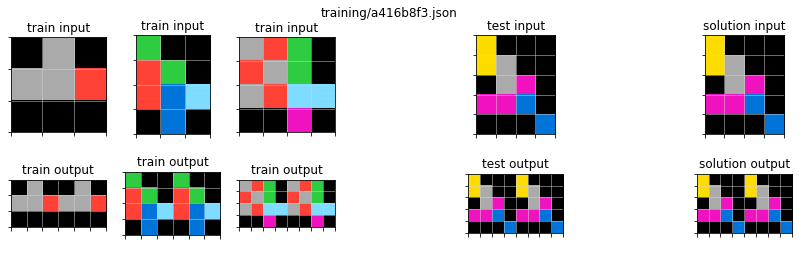

<bound method TessellationSolver.action of <__main__.TessellationSolver object at 0x7fcce6c52d10>> {'preprocess': <function copy at 0x7fcd00a5b320>, 'p_arg': (), 'transform': <function copy at 0x7fcd00a5b320>, 't_arg': (), 'query': <function query_max_color at 0x7fccdaa53200>, 'q_arg': ()}
solved:  TessellationSolver {'preprocess': <function copy at 0x7fcd00a5b320>, 'p_arg': (), 'transform': <function copy at 0x7fcd00a5b320>, 't_arg': (), 'query': <function query_max_color at 0x7fccdaa53200>, 'q_arg': ()}


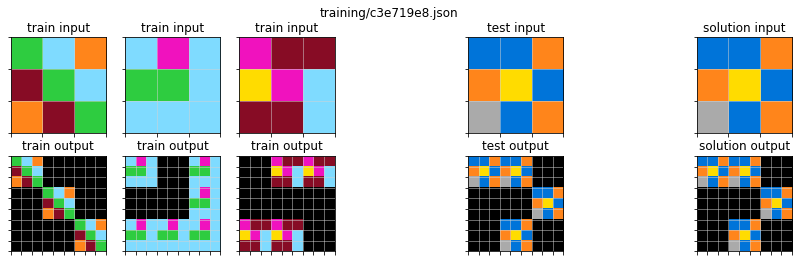

<bound method TessellationSolver.action of <__main__.TessellationSolver object at 0x7fcce6c52d10>> {'preprocess': <function copy at 0x7fcd00a5b320>, 'p_arg': (), 'transform': <function copy at 0x7fcd00a5b320>, 't_arg': (), 'query': <function query_not_zero at 0x7fccdaa53b00>, 'q_arg': ()}
solved:  TessellationSolver {'preprocess': <function copy at 0x7fcd00a5b320>, 'p_arg': (), 'transform': <function copy at 0x7fcd00a5b320>, 't_arg': (), 'query': <function query_not_zero at 0x7fccdaa53b00>, 'q_arg': ()}


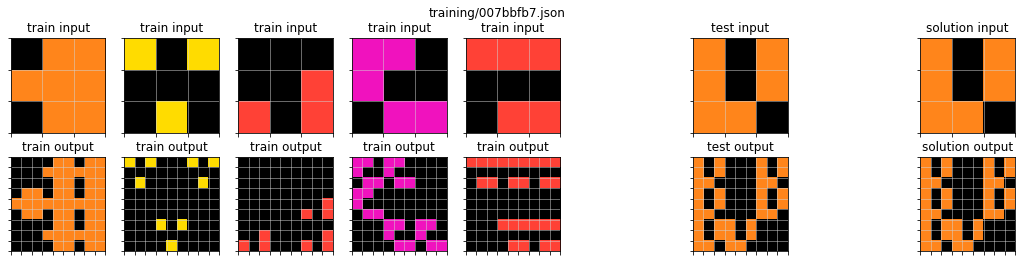

<bound method TessellationSolver.action of <__main__.TessellationSolver object at 0x7fcce6c52d10>> {'preprocess': <function copy at 0x7fcd00a5b320>, 'p_arg': (), 'transform': <function copy at 0x7fcd00a5b320>, 't_arg': (), 'query': <function query_count_colors at 0x7fccdaa53ef0>, 'q_arg': ()}
solved:  TessellationSolver {'preprocess': <function copy at 0x7fcd00a5b320>, 'p_arg': (), 'transform': <function copy at 0x7fcd00a5b320>, 't_arg': (), 'query': <function query_count_colors at 0x7fccdaa53ef0>, 'q_arg': ()}


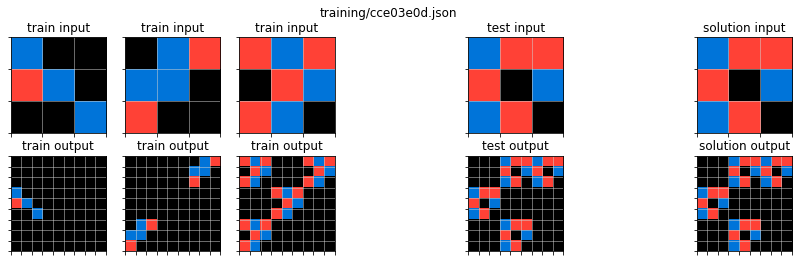

7

In [9]:
import skimage.measure
# from skimage.measure import block_reduce
import inspect
from fastcache import lru_cache
# from numpy_lru_cache_decorator import np_cache  # https://gist.github.com/Susensio/61f4fee01150caaac1e10fc5f005eb75

def query_true(grid,x,y):          return True
def query_not_zero(grid,x,y):      return grid[x,y]
def query_color(grid,x,y,color):   return grid[x,y] == color

# evaluation/15696249.json - max(1d.argmax())
def query_max_color(grid,x,y,exclude_zero=True):     
    return grid[x,y] == max_color(grid, exclude_zero)
# @lru_cache(1024)
def max_color(grid, exclude_zero=True):
    bincount = np.bincount(grid.flatten())
    if exclude_zero:    
        bincount[0] = np.min(bincount)  # exclude 0
    return bincount.argmax()

def query_min_color(grid,x,y, exclude_zero=True):     
    return grid[x,y] == min_color(grid, exclude_zero)
# @lru_cache(1024)
def min_color(grid,exclude_zero=True):
    bincount = np.bincount(grid.flatten())
    if exclude_zero:
        bincount[0] = np.max(bincount)  # exclude 0
    return bincount.argmin()

def query_max_color_1d(grid,x,y,exclude_zero=True):     
    return grid[x,y] == max_color_1d(grid)
# @lru_cache(16)
def max_color_1d(grid,exclude_zero=True):
    return max(
        [ max_color(row,exclude_zero) for row in grid ] +
        [ max_color(col,exclude_zero) for col in np.swapaxes(grid, 0,1) ]        
    )
def query_min_color_1d(grid,x,y):     
    return grid[x,y] == min_color_1d(grid)
# @lru_cache(16)
def min_color_1d(grid):
    return min(
        [ min_color(row) for row in grid ] +
        [ min_color(col) for col in np.swapaxes(grid, 0,1) ]        
    )


def query_count_colors(grid,x,y):     
    return grid[x,y] >= count_colors(grid)    
def query_count_colors_row(grid,x,y):     
    return x + len(grid.shape[0])*y <= count_colors(grid)    
def query_count_colors_col(grid,x,y):     
    return y + len(grid.shape[1])*x <= count_colors(grid)    
# @lru_cache(16)
def count_colors(grid):
    bincount = np.bincount(grid.flatten())
    return np.count_nonzero(bincount[1:]) # exclude 0

def query_count_squares(grid,x,y):     
    return grid[x,y] >= count_squares(grid)    
def query_count_squares_row(grid,x,y):     
    return x + len(grid.shape[0])*y <= count_squares(grid)    
def query_count_squares_col(grid,x,y):     
    return y + len(grid.shape[1])*x <= count_squares(grid)    
# @lru_cache(16)
def count_squares(grid):
    return np.count_nonzero(grid.flatten())

# BROKEN?
def rotate_loop(grid, start=0):    
    angle = start
    while True:
        yield np.rot90(grid, angle % 4)
        angle += 1 * np.sign(start)

# BROKEN?
def rotate_loop_rows(grid, start=0):    
    angle = start
    while True:
        yield np.rot90(grid, angle % grid.shape[0])
        angle += 1 * np.sign(start)

# BROKEN?
def rotate_loop_cols(grid, start=0):    
    angle = start
    while True:
        yield np.rot90(grid, angle % grid.shape[1])
        angle += 1 * np.sign(start)

def flip_loop(grid, start=0):    
    angle = start
    while True:
        if angle % 2: yield np.flip(grid)
        else:         yield grid
        angle += 1 * np.sign(start)

# BROKEN?
def flip_loop_rows(grid, start=0):    
    angle = start
    while True:
        if angle % grid.shape[0]: yield np.flip(grid)
        else:                     yield grid
        angle += 1 * np.sign(start)

# BROKEN?
def flip_loop_cols(grid, start=0):    
    angle = start
    while True:
        if angle % grid.shape[1]: yield np.flip(grid)
        else:                     yield grid
        angle += 1 * np.sign(start)

# BROKEN?
def invert(grid, color=None):
    if callable(color): color = color(grid)
    if color is None:   color = max_color(grid)
    if color:
        grid        = grid.copy()
        mask_zero   = grid[ grid == 0 ]
        mask_square = grid[ grid != 0 ]    
        grid[mask_zero]   = color
        grid[mask_square] = 0
    return grid    
        
    
        
# Source: https://codereview.stackexchange.com/questions/132914/crop-black-border-of-image-using-numpy         
def crop_inner(grid,tol=0): 
    mask = grid>tol; 
    return grid[np.ix_(mask.any(1),mask.any(0))]

def crop_outer(grid,tol=0):
    mask = grid>tol
    m,n  = grid.shape
    mask0,mask1 = mask.any(0),mask.any(1)
    col_start,col_end = mask0.argmax(),n-mask0[::-1].argmax()
    row_start,row_end = mask1.argmax(),m-mask1[::-1].argmax()
    return grid[row_start:row_end,col_start:col_end]

def make_tuple(args):
    if isinstance(args, tuple): return args
    if isinstance(args, list):  return tuple(args)
    return (args,)


class TessellationSolver(GeometrySolver):
    verbose = True
    debug   = False
    options = {
        "preprocess": { 
            "np.copy":    (np.copy, []), 
            "crop_inner": (crop_inner, range(0,9)),
            "crop_outer": (crop_outer, range(0,9)),
        },
        "transform": {  
            "none":              ( np.copy,      []        ),
            "flip":              ( np.flip,      [0,1]     ),
            "rot90":             ( np.rot90,     [1,2,3]   ),
            "roll":              ( np.roll,      product([-1,1],[0,1]) ),  
            "swapaxes":          ( np.swapaxes,  [(0, 1)]  ),                         
            "rotate_loop":       ( rotate_loop,         range(-4,4) ),
            "rotate_loop_rows":  ( rotate_loop_rows,    range(-4,4) ),  # BROKEN ?
            "rotate_loop_cols":  ( rotate_loop_cols,    range(-4,4) ),  # BROKEN ?          
            "flip_loop":         ( flip_loop,           range(0,2)  ),  # BROKEN ?
            "flip_loop_rows":    ( flip_loop_rows,      range(0,2)  ),  # BROKEN ?
            "flip_loop_cols":    ( flip_loop_cols,      range(0,2)  ),  # BROKEN ?
            "invert":            ( invert,              [max_color, min_color, max_color_1d, count_colors, count_squares, *range(1,9)]  ), # BROKEN
            # TODO: Invert
        },
        "query": {
            "query_true":              ( query_true,          [] ),
            "query_not_zero":          ( query_not_zero,      [] ),  
            "query_max_color":         ( query_max_color,     [] ),
            "query_min_color":         ( query_min_color,     [] ),
            "query_max_color_1d":      ( query_max_color_1d,  [] ),
            "query_min_color_1d":      ( query_min_color_1d,  [] ),
            "query_count_colors":      ( query_count_colors,      [] ),
            "query_count_colors_row":  ( query_count_colors_row,  [] ),
            "query_count_colors_col":  ( query_count_colors_col,  [] ),            
            "query_count_squares":     ( query_count_squares,     [] ),
            "query_count_squares_row": ( query_count_squares_row, [] ),
            "query_count_squares_col": ( query_count_squares_col, [] ),
            "query_color":             ( query_color,         range(0,10) ),  # TODO: query_max_color() / query_min_color()
        }
    }

    
    def detect(self, task):
        if self.is_task_shape_ratio_unchanged(task):            return False  # Use GeometrySolver
        if not self.is_task_shape_ratio_integer_multiple(task): return False  # Not a Tessalation problem   
        if not all([ count_colors(spec['input']) == count_colors(spec['output']) for spec in task['train'] ]): return False  # Different colors 
        if ZoomSolver().solve(task):                            return False
        #if not self.is_task_shape_ratio_consistant(task):       return False  # Some inconsistant grids are tessalations
        return True


    
    def loop_options(self):
        for (preprocess,p_args) in self.options['preprocess'].values():
            # print( (preprocess,p_args) )
            for p_arg in p_args or [()]:
                p_arg = make_tuple(p_arg)
                # print( (preprocess,p_args) )
                for (transform,t_args) in self.options['transform'].values():
                    for t_arg in t_args or [()]:
                        t_arg = make_tuple(t_arg)
                        for (query,q_args) in self.options['query'].values():
                            for q_arg in q_args or [()]:
                                q_arg = make_tuple(q_arg)
                                yield (preprocess, p_arg),(transform,t_arg),(query,q_arg)
    
    # TODO: hieraracharical nesting of solves and solutions/rules array generator
    def test(self, task):
        if task['file'] in self.cache: return True
        for (preprocess,p_arg),(transform,t_arg),(query,q_arg) in self.loop_options():         
            kwargs = {                
                "preprocess": preprocess,
                "p_arg":      p_arg,
                "transform":  transform,  # TODO: invert every other row | copy pattern from train outputs | extend lines
                "t_arg":      t_arg,
                "query":      query,  # TODO: max_colour limit counter
                "q_arg":      q_arg,
            }                        
            if self.is_lambda_valid(task, self.action, **kwargs, task=task):
                self.cache[task['file']] = kwargs
                if self.verbose: print(self.action, kwargs)
                return True
        return False
        
       
    def action(self, grid, preprocess=np.copy, p_arg=(), transform=np.copy, t_arg=(), query=query_true, q_arg=(), task=None):         
        #print('action', preprocess, transform, query)
        if inspect.isgeneratorfunction(transform):
            generator = transform(grid, *t_arg)
            transform = lambda grid, *args: next(generator)
        
        # Some combinations of functions will throw gemoetry             
        try:                                        
            grid    = preprocess(grid, *p_arg) 
            output  = self.get_output_grid(grid, task).copy()
            ratio   = ( int(output.shape[0] / grid.shape[0]), int(output.shape[1] / grid.shape[1]) )
            (gx,gy) = grid.shape
            for x,y in product(range(ratio[0]),range(ratio[1])):
                copy = np.zeros(grid.shape)
                if query(grid,x%gx,y%gy, *q_arg):            
                    copy = transform(grid, *t_arg)

                output[x*gx:(x+1)*gx, y*gy:(y+1)*gy] = copy
        except Exception as exception: 
            if self.debug: print(exception)
            pass
        return output
    
    
    def loop_ratio(self, task):
        ratio = list(self.task_shape_ratios(task))[0]
        for i in range(int(ratio[0])):
            for j in range(int(ratio[1])):            
                yield i,j

                
    def get_output_grid(self, grid, task):
        try:
            #print('get_output_grid(self, grid, task)', grid, task)
            for index, spec in enumerate(task['train']):
                if spec['input'] is grid:
                    return spec['output']
            else:
                # No output for tests
                ratio = list(self.task_shape_ratios(task))[0]
                ratio = list(map(int, ratio))
                shape = ( int(grid.shape[0]*ratio[0]), int(grid.shape[1]*ratio[1]) )
                return np.zeros(shape)
        except Exception as exception: 
            if self.debug: print(exception)
            pass
            
     
solvers['TessellationSolver'] = TessellationSolver()
solvers['TessellationSolver'].plot(tasks)

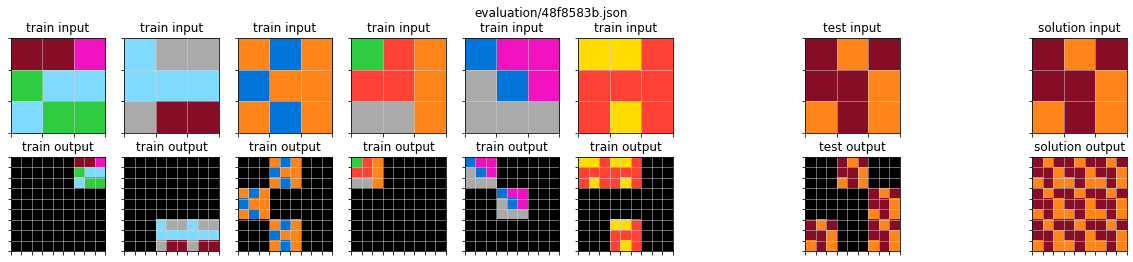

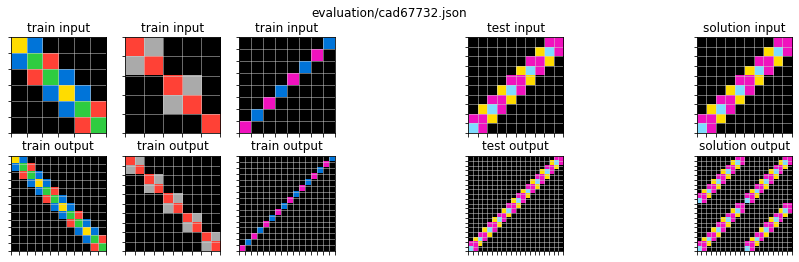

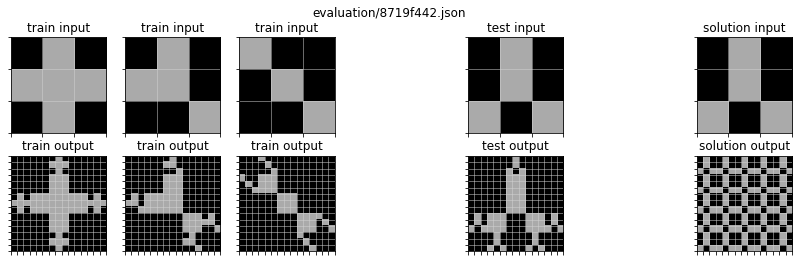

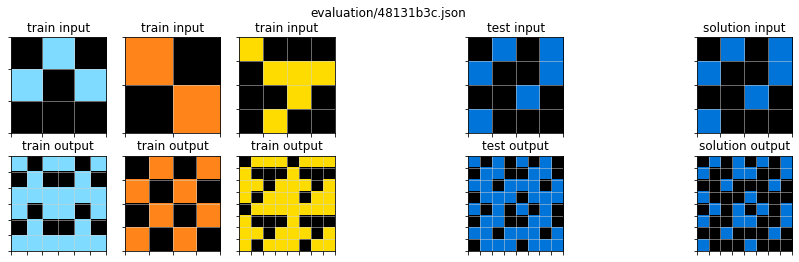

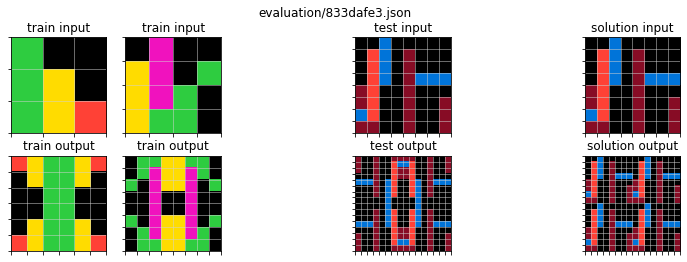

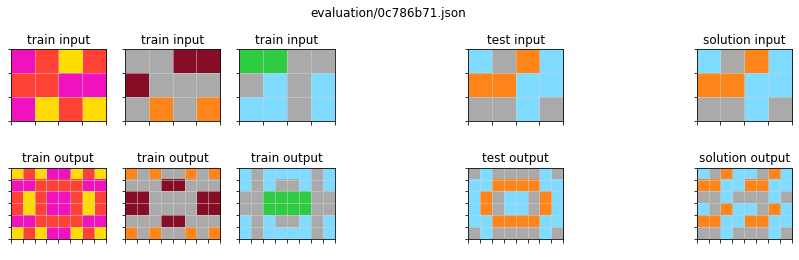

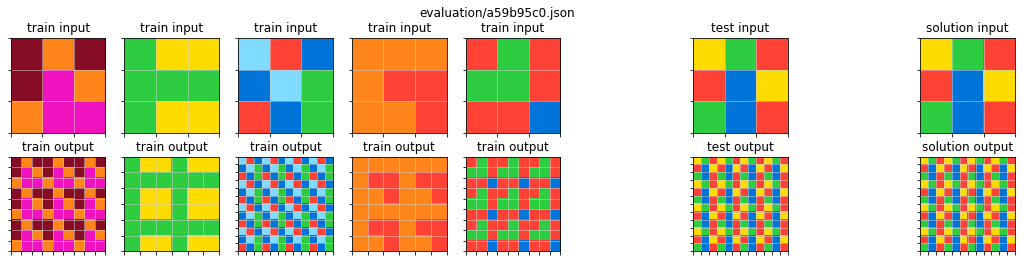

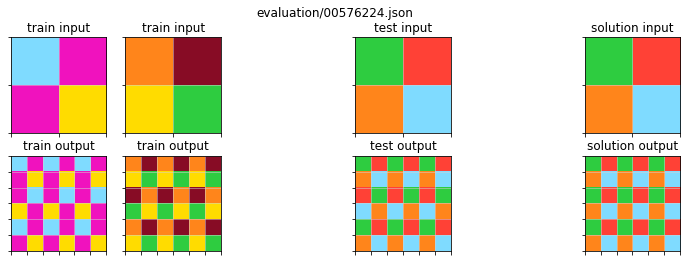

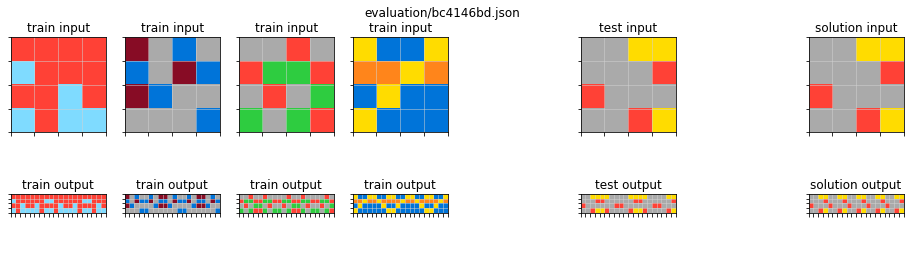

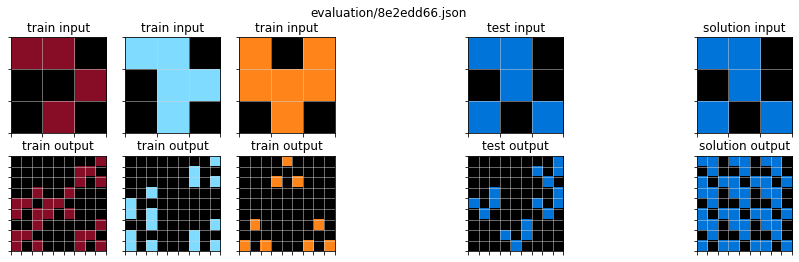

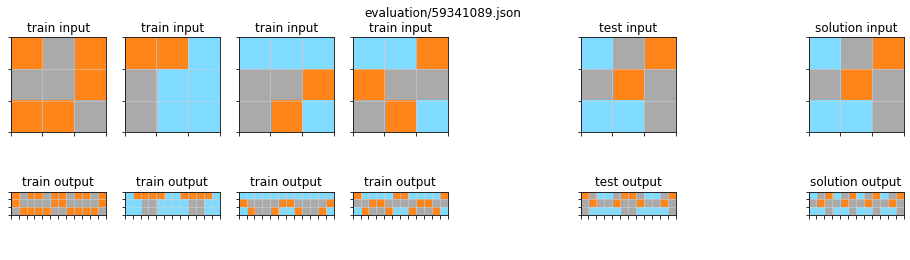

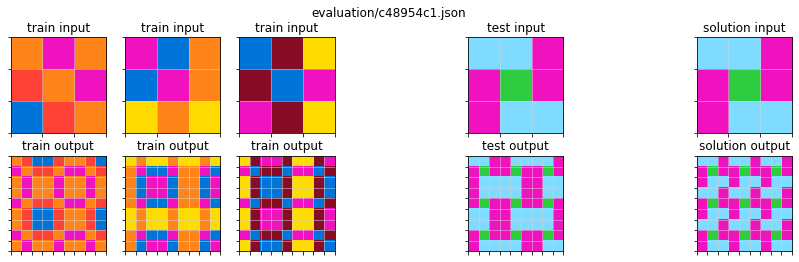

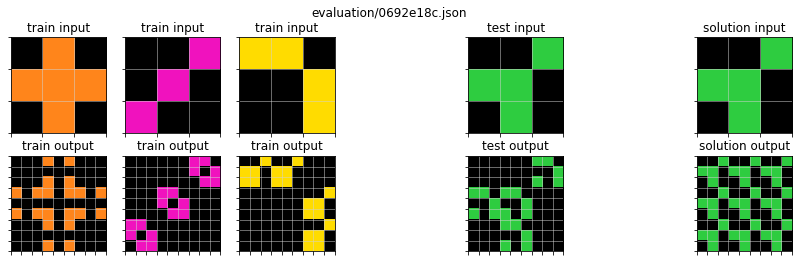

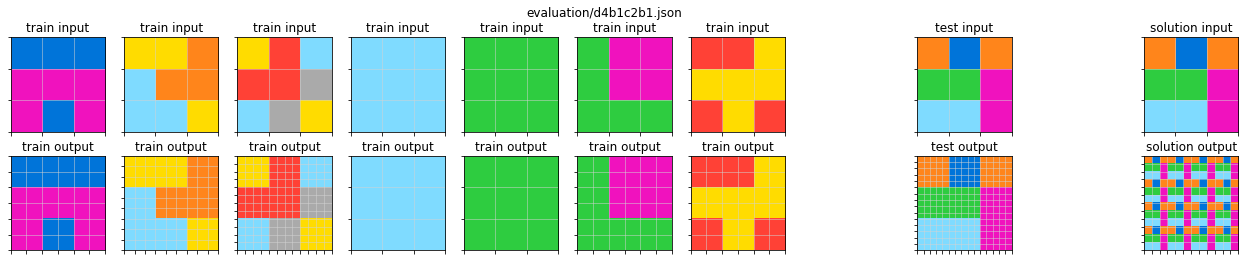

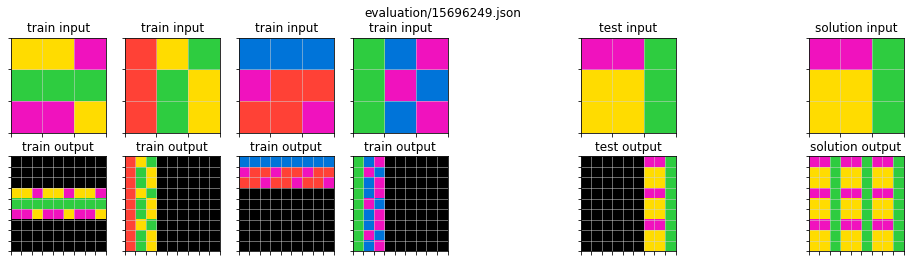

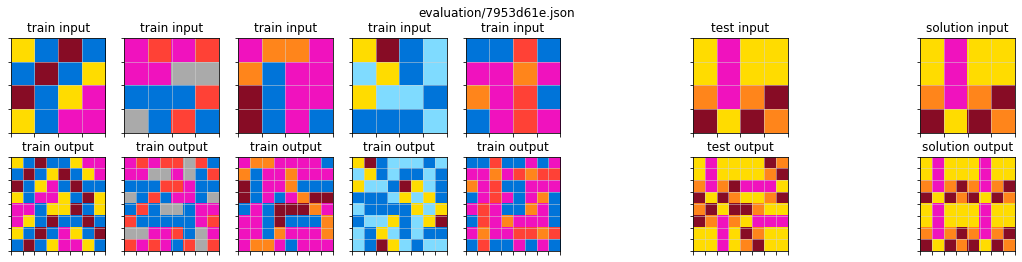

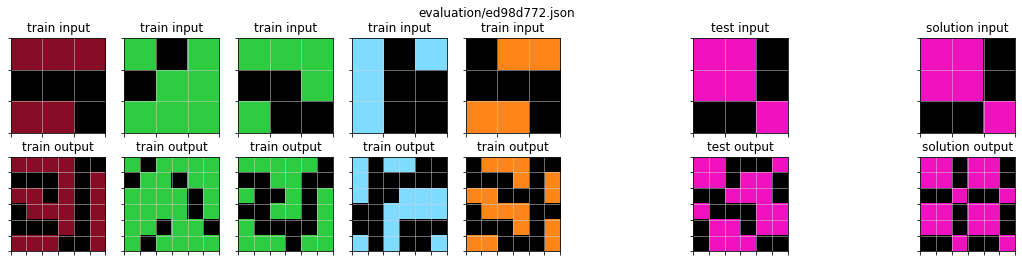

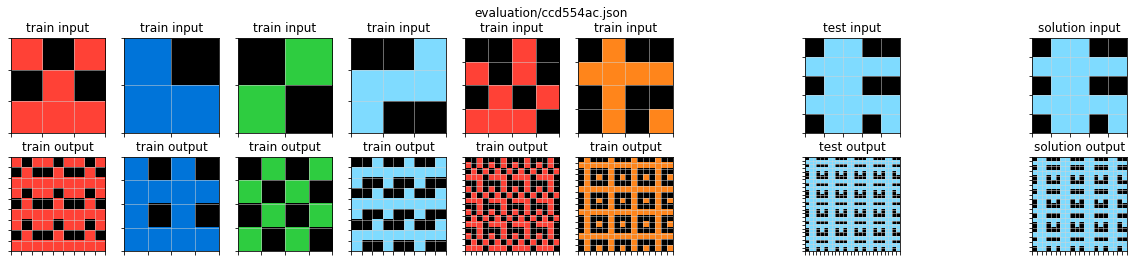

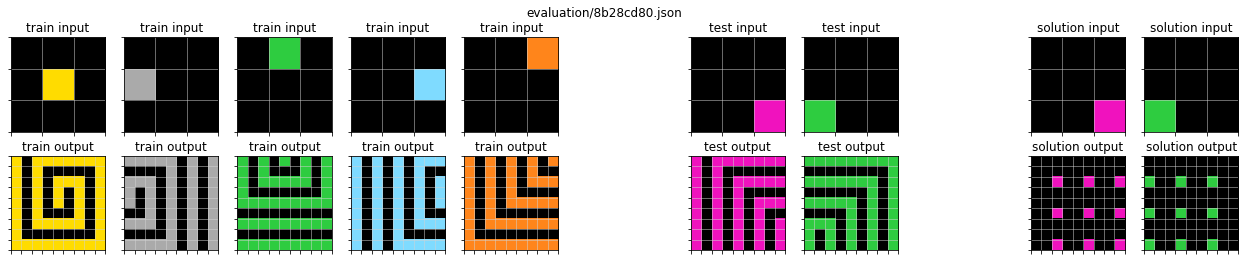

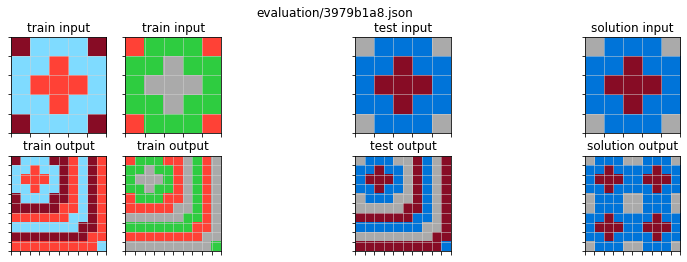

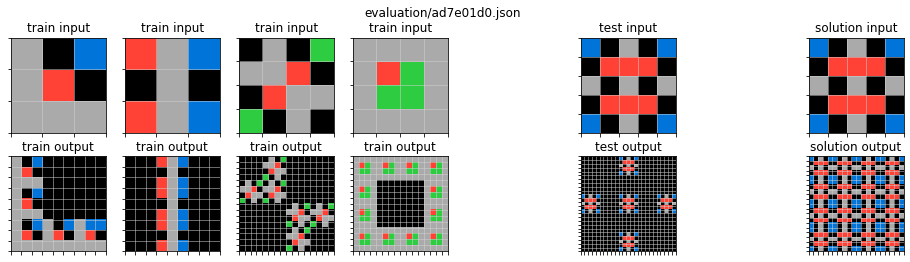

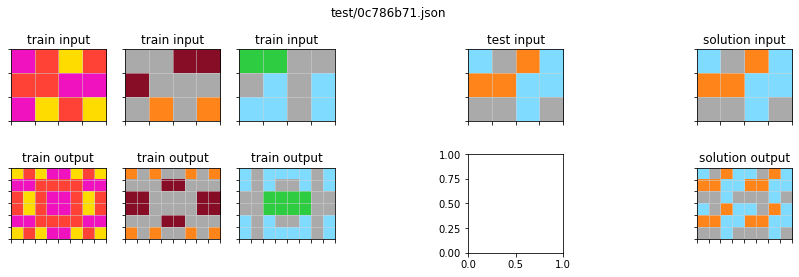

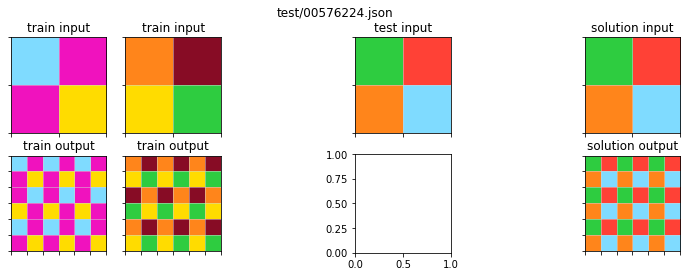

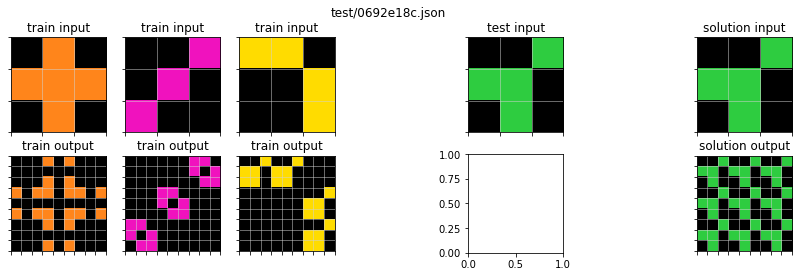

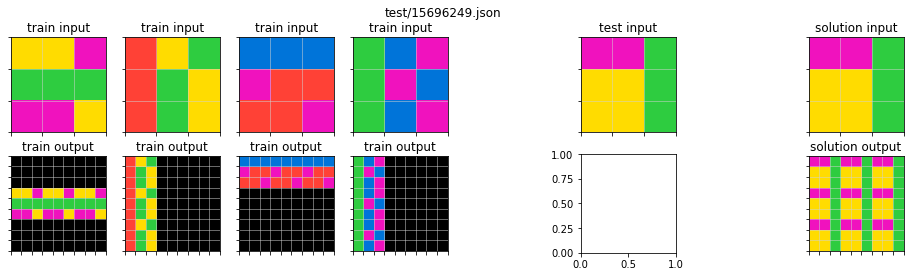

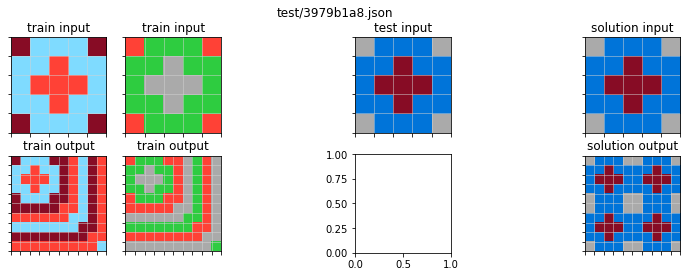

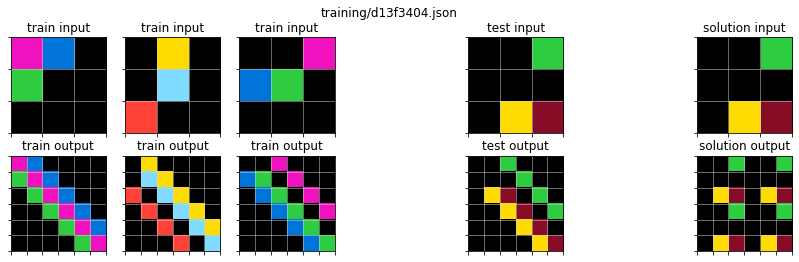

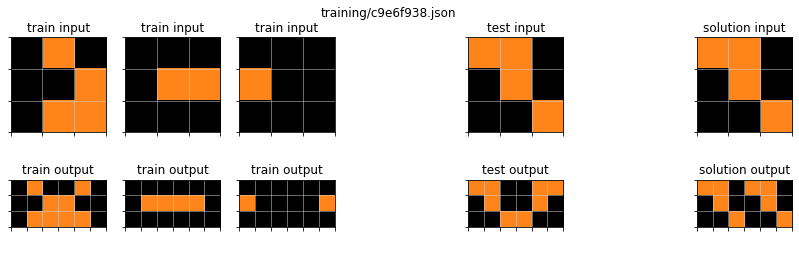

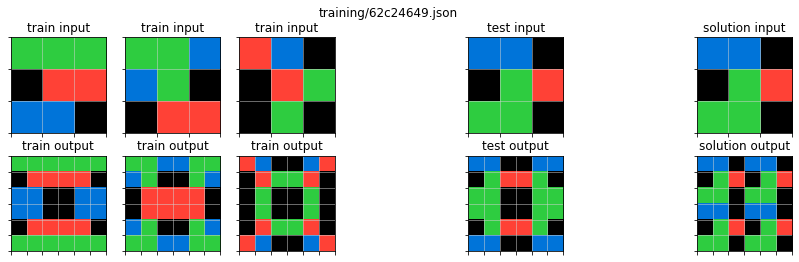

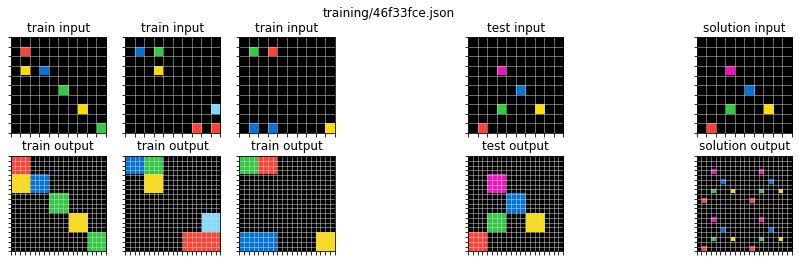

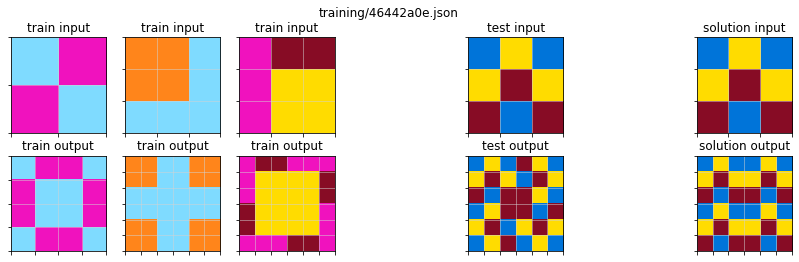

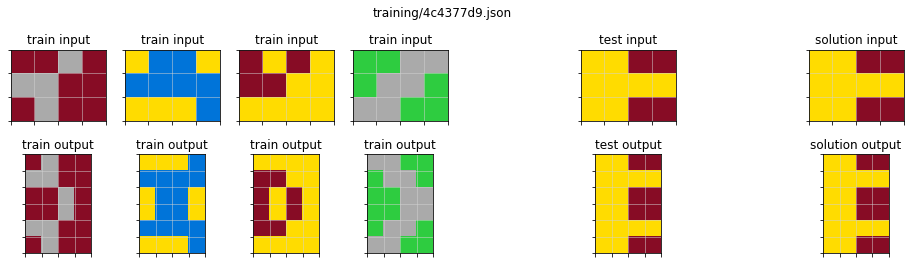

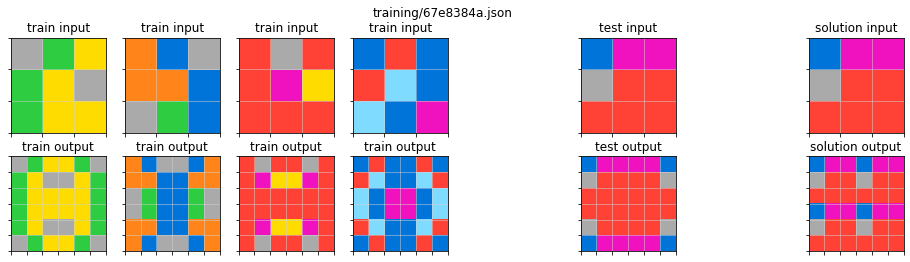

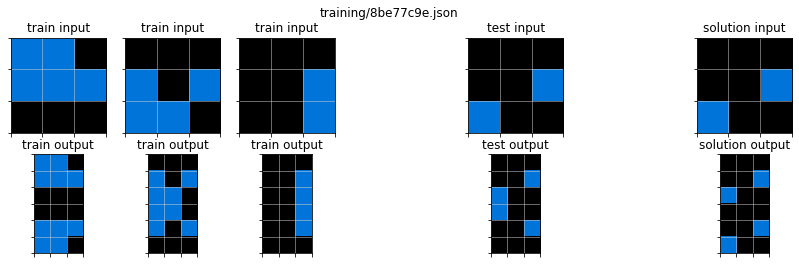

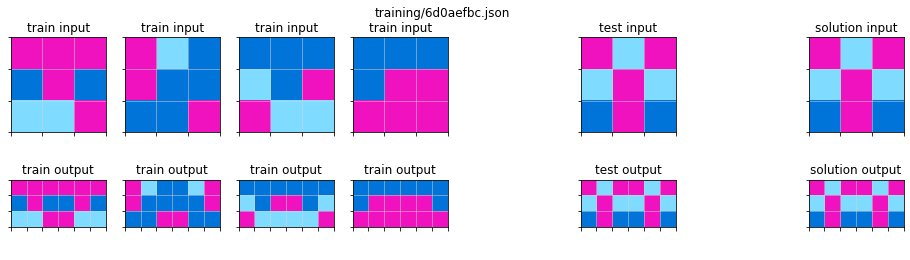

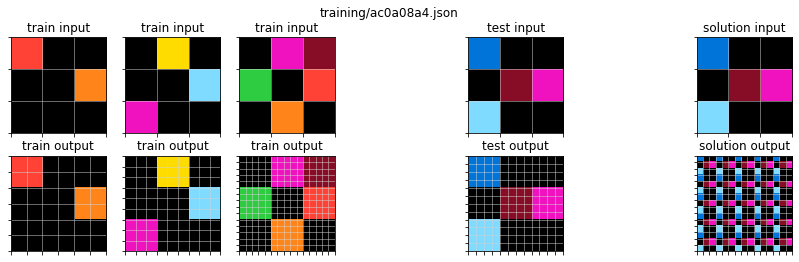

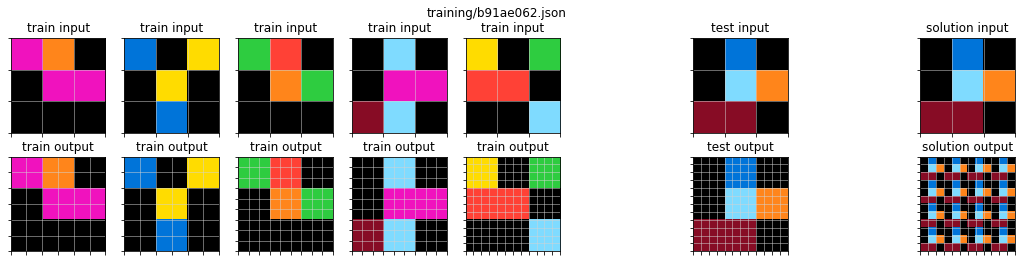

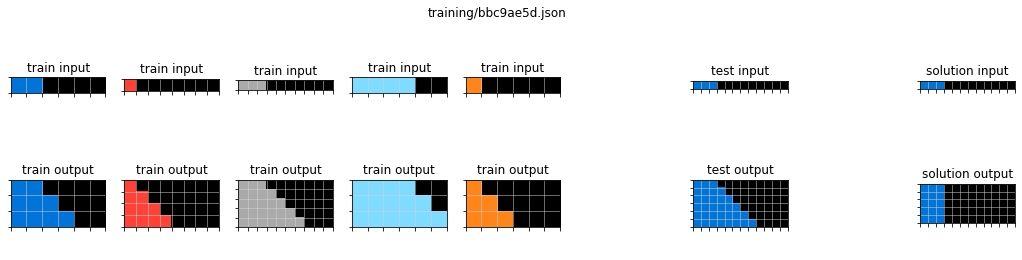

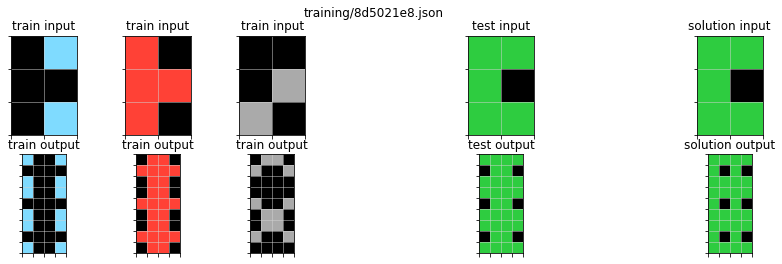

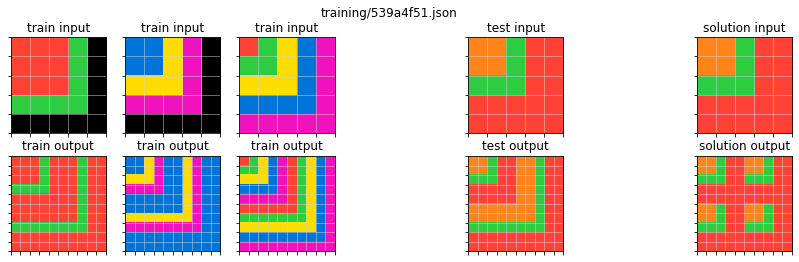

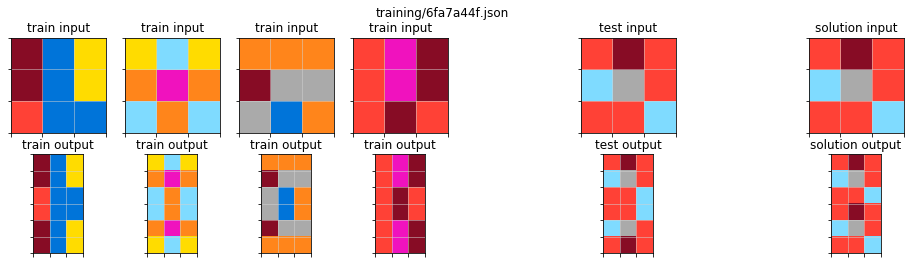

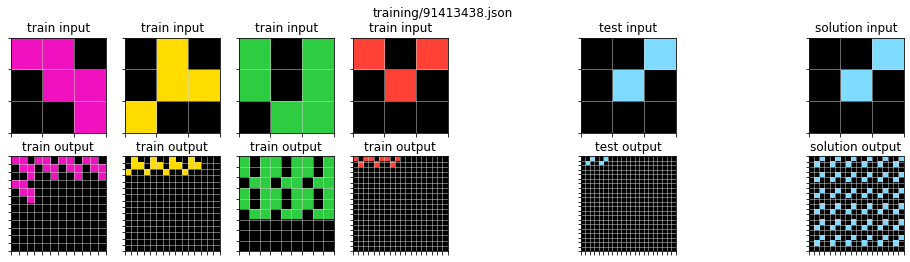

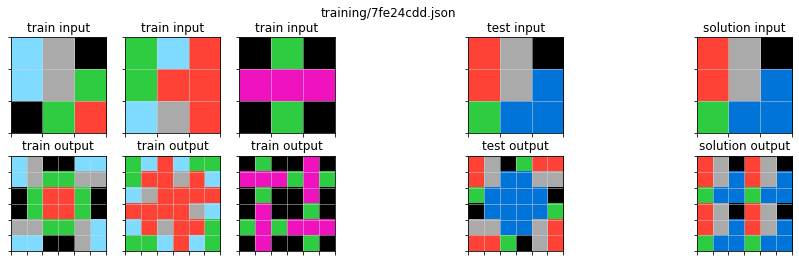

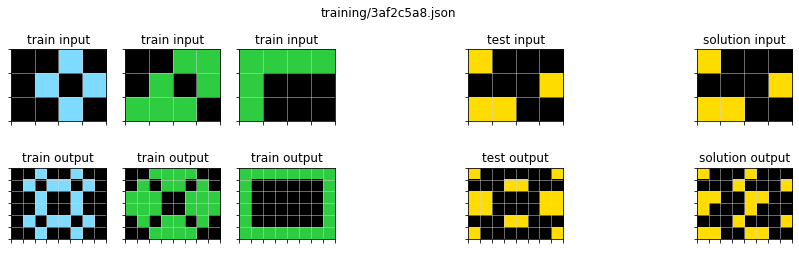

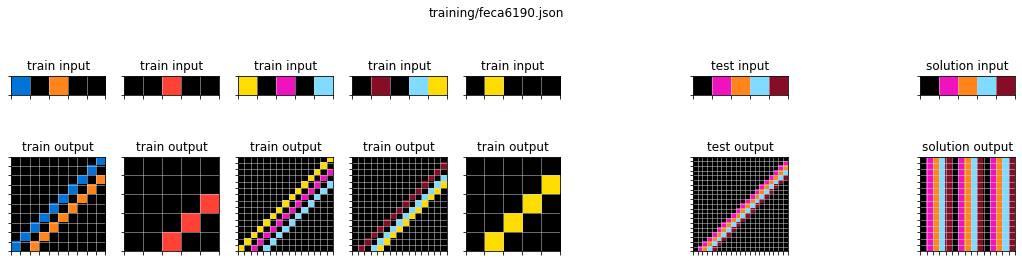

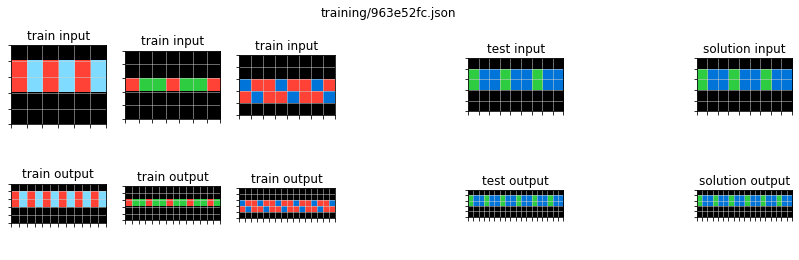

46

In [10]:
from copy import deepcopy
solvers['TessellationSolver'].plot_detects(tasks)

# Fill In Blank Areas

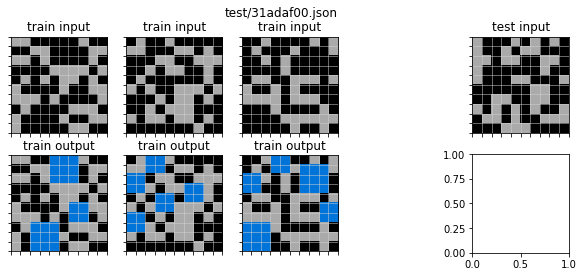

In [11]:
plot_task('test/31adaf00.json')

# Border Problems

<bound method BorderSolver.action of <__main__.BorderSolver object at 0x7fccdb7fe150>> [8]
solved:  BorderSolver [8]


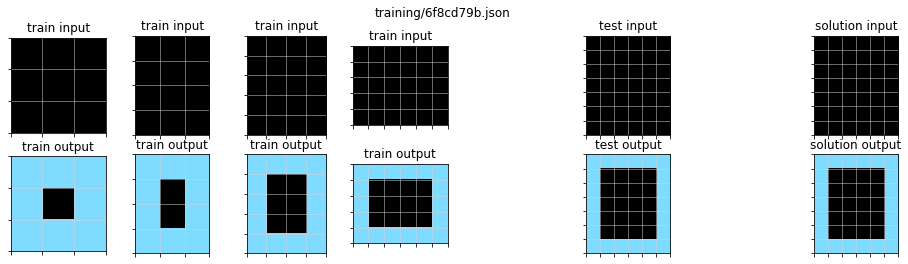

1

In [12]:
class BorderSolver(Solver):
    verbose = True
    debug = True
    cache = {}
    queries = [
        *range(0,10),
        max_color,     # FAIL: evaluation/fc754716.json
        max_color_1d,
        min_color,
        min_color_1d,
        count_colors,
        count_squares,
        np.count_nonzero,
    ]

    def task_has_border(self, task): 
        if not self.is_task_shape_ratio_consistant(task): return False        
        return all([ self.grid_has_border(spec['output']) for spec in task['train'] ])
        
    def grid_has_border(self, grid):
        if min(grid.shape) <= 2:                          return False  # single color problem

        grid_center = grid[1:-1,1:-1]        
        return np.count_nonzero(grid_center) == 0 and all([
            np.count_nonzero(border) == len(border)
            for border in [ grid[0,:], grid[-1,:], grid[:,0], grid[:,-1] ]
        ])
    
    def detect(self, task):
        return self.task_has_border(task)
    
    def test(self, task):
        if task['file'] in self.cache: return True
        for query in self.queries:         
            args = [ query ]
            if self.is_lambda_valid(task, self.action, *args, task=task):
                self.cache[task['file']] = args
                if self.verbose: print(self.action, args)
                return True
        return False
        
    def action(self, grid, query=None, task=None):
        ratio  = list(self.task_shape_ratios(task))[0]
        output = np.zeros(( int(grid.shape[0] * ratio[0]), int(grid.shape[1] * ratio[1]) ))
        color  = query(grid) if callable(query) else query 
        output[:,:] = color
        output[1:-1,1:-1] = 0
        return output

solvers['BorderSolver'] = BorderSolver()
solvers['BorderSolver'].plot(tasks)

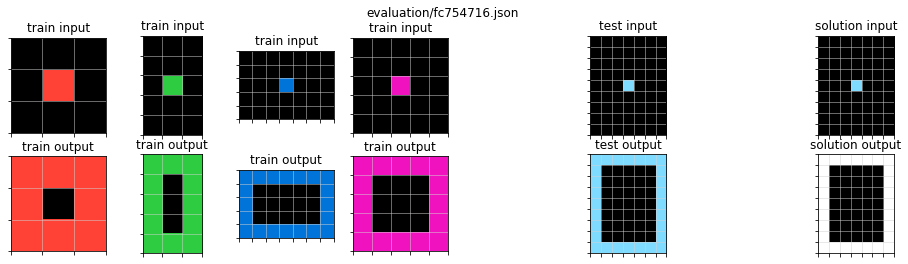

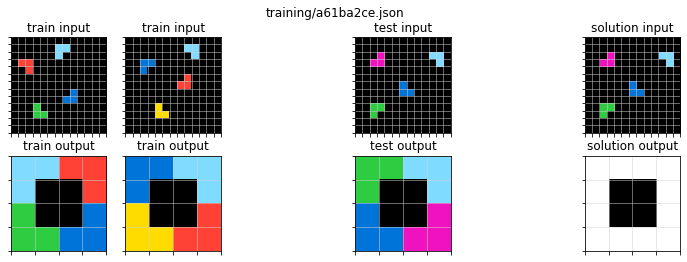

2

In [13]:
solvers['BorderSolver'].plot_detects(tasks)

# Single Color Problems

<bound method SingleColorSolver.action of <__main__.SingleColorSolver object at 0x7fccdb4d2650>> [<function max_color at 0x7fccdaa53320>]
solved:  SingleColorSolver [<function max_color at 0x7fccdaa53320>]


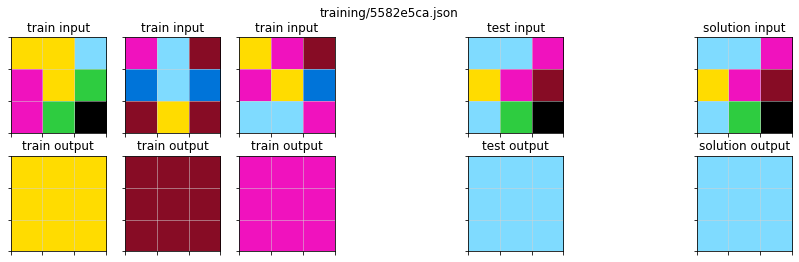

<bound method SingleColorSolver.action of <__main__.SingleColorSolver object at 0x7fccdb4d2650>> [<function max_color at 0x7fccdaa53320>]
solved:  SingleColorSolver [<function max_color at 0x7fccdaa53320>]


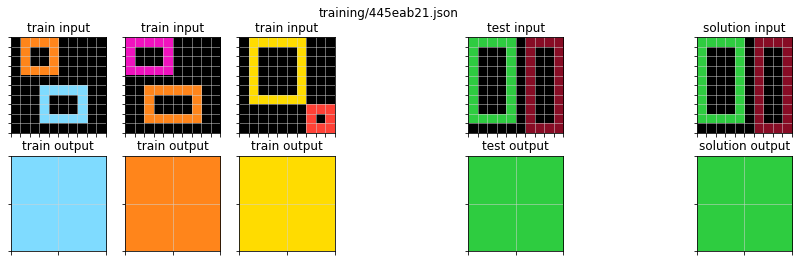

2

In [14]:
class SingleColorSolver(Solver):
    verbose = True
    debug = True
    cache = {}
    queries = [
        *range(0,10),
        max_color,     # FAIL: evaluation/fc754716.json
        max_color_1d,
        min_color,
        min_color_1d,
        count_colors,
        count_squares,
        np.count_nonzero,
    ]

    def grid_unique_colors(self, grid):
        return np.unique(grid.flatten())
    
    def task_is_singlecolor(self, task): 
        if not self.is_task_shape_ratio_consistant(task): return False        
        return all([ len(self.grid_unique_colors(spec['output'])) == 1 for spec in task['train'] ])
                
    def detect(self, task):
        return self.task_is_singlecolor(task)
    
    def test(self, task):
        if task['file'] in self.cache: return True
        for query in self.queries:         
            args = [ query ]
            if self.is_lambda_valid(task, self.action, *args, task=task):
                self.cache[task['file']] = args
                if self.verbose: print(self.action, args)
                return True
        return False
        
    def action(self, grid, query=None, task=None):
        ratio  = list(self.task_shape_ratios(task))[0]
        output = np.zeros(( int(grid.shape[0] * ratio[0]), int(grid.shape[1] * ratio[1]) ))        
        color  = query(grid) if callable(query) else query 
        output[:,:] = color
        return output

solvers['SingleColorSolver'] = SingleColorSolver()
solvers['SingleColorSolver'].plot(tasks)

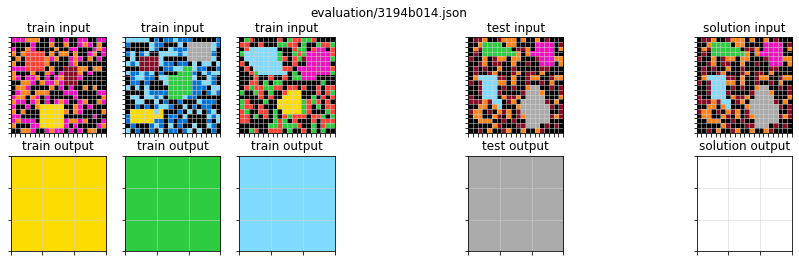

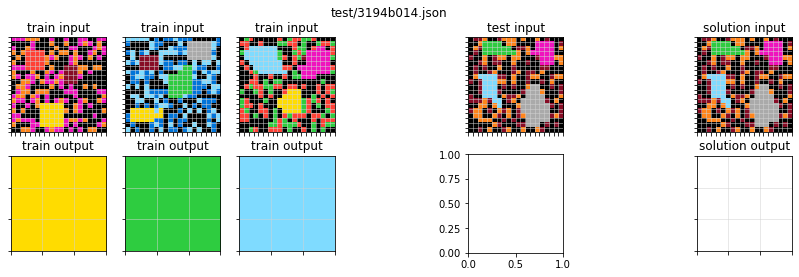

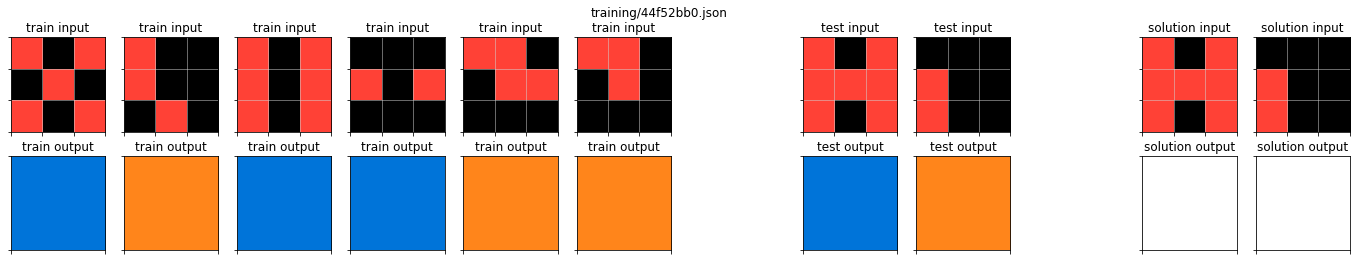

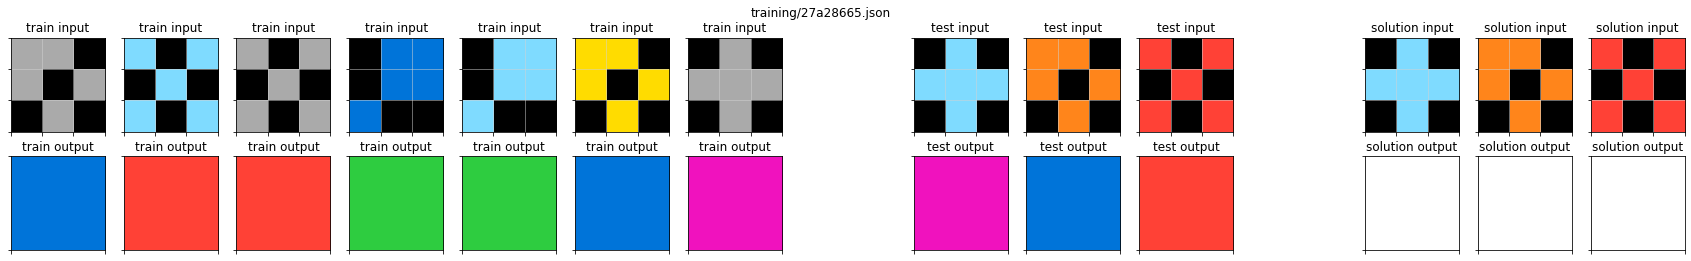

4

In [15]:
solvers['SingleColorSolver'].plot_detects(tasks)

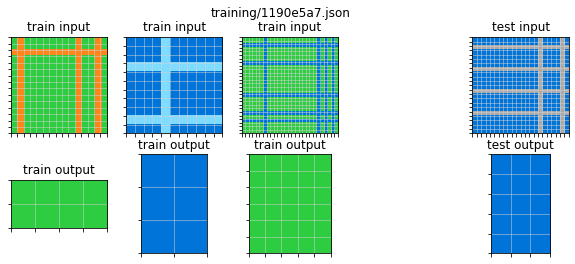

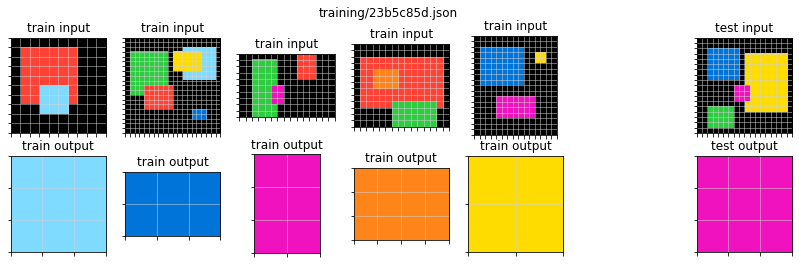

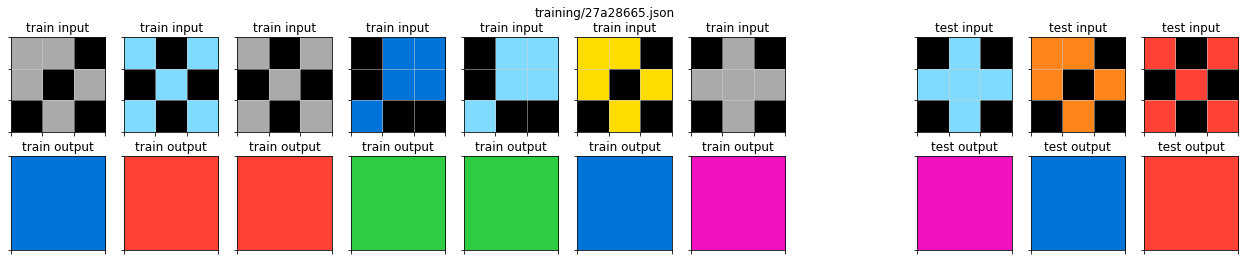

In [16]:
plot_task('training/1190e5a7.json')
plot_task('training/23b5c85d.json')
plot_task('training/27a28665.json')

# Scores

In [17]:
def score_tasks(tasks: dict, label: str):
    total  = 0
    solved = 0

    for task_file, task in tasks.items():
        for index, spec in enumerate(task['test']): total += 1            

        if 'solution' in task:
            for index, spec in enumerate(task['solution']): 
                solved += 1                
        
    print(f'{label.ljust(11)}| solutions found: {str(solved).rjust(3)}/{total} | error: {round(1-solved/total,4)}')
    return solved

for label in ['training', 'evaluation', 'test']:
    score_tasks({ file: task for (file,task) in tasks.items() if label in file }, label)

training   | solutions found:  18/416 | error: 0.9567
evaluation | solutions found:   4/419 | error: 0.9905
test       | solutions found:   1/104 | error: 0.9904


# Test Submission

The tests are a little more tricky than the simplest problems in the training dataset. As such, all the above work only finds a single solution in the test dataset.

In [18]:
test_files = glob('../input/abstraction-and-reasoning-challenge/test/*.json'); 
tests = load_tasks(test_files)
len(tests)

100

<bound method TessellationSolver.action of <__main__.TessellationSolver object at 0x7fcce6c52d10>> {'preprocess': <function copy at 0x7fcd00a5b320>, 'p_arg': (), 'transform': <function copy at 0x7fcd00a5b320>, 't_arg': (), 'query': <function query_max_color at 0x7fccdaa53200>, 'q_arg': ()}
solved:  TessellationSolver {'preprocess': <function copy at 0x7fcd00a5b320>, 'p_arg': (), 'transform': <function copy at 0x7fcd00a5b320>, 't_arg': (), 'query': <function query_max_color at 0x7fccdaa53200>, 'q_arg': ()}


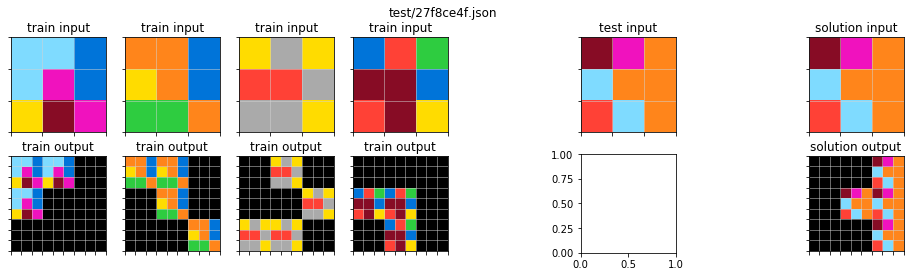

In [19]:
for name, solver in solvers.items():
    solver.cache = {}
    solver.plot(tests)

Evaluation Submission Format:
- https://www.kaggle.com/c/abstraction-and-reasoning-challenge/overview/evaluation

In [20]:
# def output_id(filename, index=0):
#     return re.sub('^.*/|\.json$', '', filename) + '_' + str(index);

# def output_grid(grid):
#     grid   = grid.astype('uint8').tolist()
#     # output = " ".join([
#     #     '|' + "".join([ str(int(cell)) for cell in row ]) + '|'
#     #     for row in grid
#     # ])
#     output = (
#         json.dumps(grid)
#             .replace(', ', '')
#             .replace('[[', '|')
#             .replace('][', '|')
#             .replace(']]', '|')
#     )
#     return output

# def output_csv(tests, submission_file='submission.csv', verbose=True):
#     output = []
#     for task_file, test in tests.items():
#         if 'solution' in test: 
#             for index, spec in enumerate(test['solution']): 
#                 output.append([ output_id(task_file, index), output_grid(spec['output']) ])
#         else:
#             for index, spec in enumerate(test['test']):             
#                 output.append([ output_id(task_file, index), output_grid(spec['input']) ])            

#     output = [['output_id','output']] + sorted(output)
#     csv = "\n".join([ ",".join(row) for row in output ])

#     with open(submission_file, 'w') as file:
#         file.write(csv)
#         if verbose: print(f'wrote: {submission_file}')

# output_csv(tests, 'submission.csv')

In [21]:
import pandas as pd

def output_id(filename, index=0):
    return re.sub('^.*/|\.json$', '', filename) + '_' + str(index);

# Source: https://www.kaggle.com/c/abstraction-and-reasoning-challenge/overview/evaluation
def flattener(grid):
    grid = grid.astype('uint8').tolist()    
    str_pred = str([row for row in grid])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

def write_submission_csv(tests):
    submission_csv = pd.read_csv('../input/abstraction-and-reasoning-challenge/sample_submission.csv')
    submission_csv = submission_csv.set_index('output_id')

    total  = 0
    solved = 0
    for task_file, test in tests.items():    
        for index, spec in enumerate(test['test']): total += 1
        if 'solution' in test:
            for index, spec in enumerate(test['solution']): 
                submission_csv.loc[ output_id(task_file, index), 'output' ] = flattener(spec['output'])
                solved += 1                
        
                
    submission_csv.to_csv('submission.csv')
    print(f'wrote: submission.csv')
    print(f'solutions found: {solved}/{total} | error: {round(1-solved/total,4)}')
    return submission_csv

write_submission_csv(tests)

wrote: submission.csv
solutions found: 1/104 | error: 0.9904


,output
output_id,
00576224_0,|32|78| |32|78| |00|00|
009d5c81_0,|00000000000000|00000888888888|00000800080808|...
00dbd492_0,|00000000000222220000|02222222220200020000|020...
03560426_0,|0000000000|0000000000|0000000000|0000000000|0...
05a7bcf2_0,|000000000020000000080000000000|00000000002220...
...,...
3ee1011a_0,|00000000000000000000000|000000000000000000000...
3f23242b_0,|0000000000000000000|0000000000000000000|00000...
40f6cd08_0,|000000000000000000000000000000|00112284448221...
